In [1]:
from pathlib import Path
from glob import glob
import pickle
import matplotlib.pyplot as plt
from ravens.utils import utils
import cv2
import numpy as np
import os
from pyk4a import PyK4A, Config,config,connected_device_count
import plotly.express as px

2022-07-05 09:10:03.112977: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
pybullet build time: May 20 2022 19:43:01


# Generate TableTop from Real Files

In [2]:
camera_folder="camera_0_neu"

## Load Camera Calibration

In [3]:
intrinsic = np.load("intrinsic_"+camera_folder+".npy")
intrinsic_better = np.load("intrinsic_better_"+camera_folder+".npy")
dist = np.load("dist_"+camera_folder+".npy")
rotation = np.load("rotation_"+camera_folder+".npy")
translation = np.load("translation_"+camera_folder+".npy")
intrinsic,intrinsic_better, rotation, translation,dist

(array([[614.94695641,   0.        , 640.0889173 ],
        [  0.        , 614.546995  , 368.19560945],
        [  0.        ,   0.        ,   1.        ]]),
 array([[625.222229  ,   0.        , 638.07092634],
        [  0.        , 624.22393799, 368.16188378],
        [  0.        ,   0.        ,   1.        ]]),
 array([[-0.51891813],
        [ 0.59914461],
        [ 1.47405833]]),
 array([[ 0.12691925],
        [-0.0308574 ],
        [ 0.53732928]]),
 array([[ 8.81646928e-02, -4.99471699e-02,  2.63586813e-05,
         -5.91906272e-04, -3.08759099e-03]]))

In [4]:
images = glob('./'+camera_folder+'/calibration_[0-9]*')
rgb_file_name = images[np.where(np.array([name.find("orig") for name in images]) > -1)[0][0]]
depth_file_name = "./"+camera_folder+"/calibration_depth_497.npy"

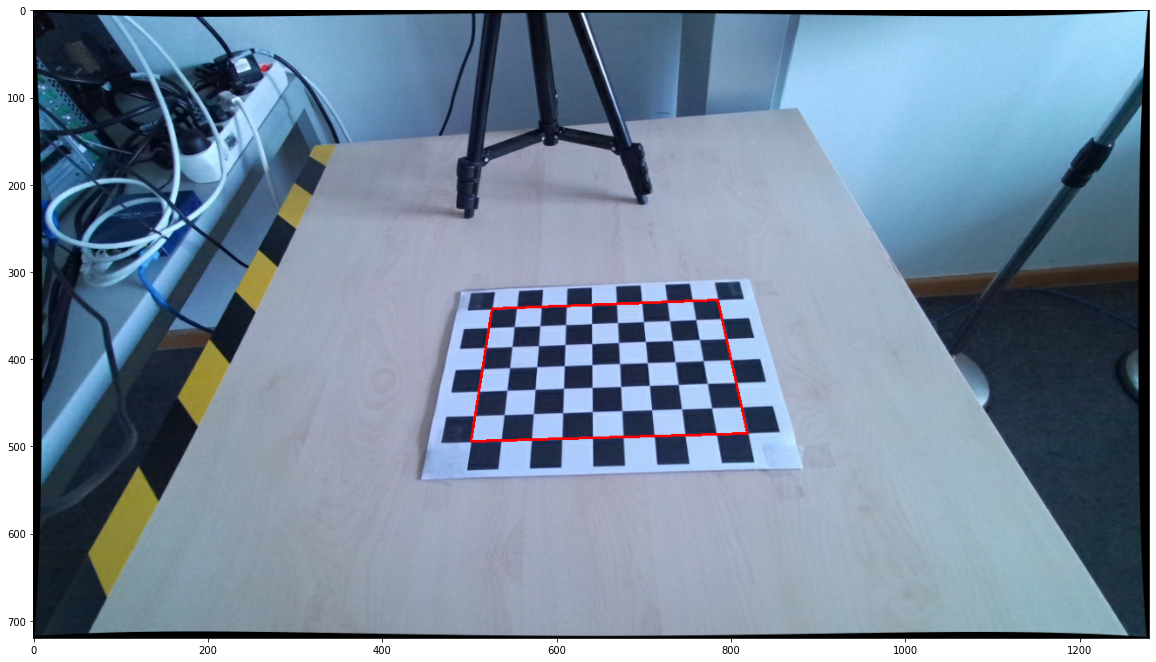

In [5]:
kinect_img = cv2.cvtColor(np.load(rgb_file_name),cv2.COLOR_BGR2RGB)
kinect_depth = np.load(depth_file_name)/1000

kinect_depth = cv2.undistort(
    kinect_depth, intrinsic, dist, None, intrinsic_better
)


kinect_img = cv2.undistort(
    kinect_img, intrinsic, dist, None, intrinsic_better
)

points = np.array([[[0.0,0.0,0.0],
                    [0.0,0.225,0.0],
                    [0.15,0.225,0.0],
                    [0.15,0.0,0.0]]])

imgpoints2, _ = cv2.projectPoints(points, rotation, translation, intrinsic_better, np.array([]))
imgpoints2 = np.squeeze(imgpoints2)

cv2.line(kinect_img, tuple(imgpoints2[0].astype(int)),tuple(imgpoints2[1].astype(int)), (255,0,0),2)
cv2.line(kinect_img, tuple(imgpoints2[1].astype(int)),tuple(imgpoints2[2].astype(int)), (255,0,0),2)
cv2.line(kinect_img, tuple(imgpoints2[2].astype(int)),tuple(imgpoints2[3].astype(int)), (255,0,0),2)
cv2.line(kinect_img, tuple(imgpoints2[3].astype(int)),tuple(imgpoints2[0].astype(int)), (255,0,0),2)

plt.subplots(figsize=(20,20))
plt.imshow(kinect_img)   

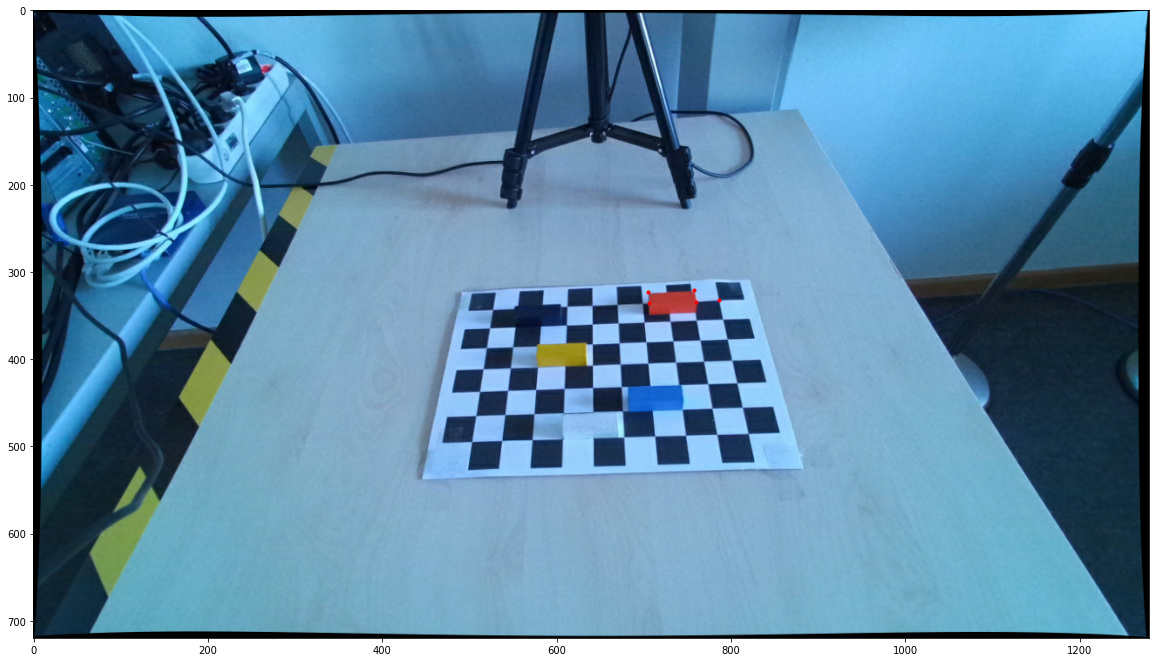

In [6]:
k4a = PyK4A(
        device_id=0,
        config=Config(
            color_resolution=config.ColorResolution.RES_720P,
            color_format=config.ImageFormat.COLOR_BGRA32,
            camera_fps=config.FPS.FPS_15,
            depth_mode=config.DepthMode.WFOV_UNBINNED,
        )
    )
k4a.start()
capture = k4a.get_capture()
kinect_img = cv2.cvtColor(capture.color,cv2.COLOR_BGR2RGB)
kinect_depth = capture.transformed_depth.astype(float)/1000
k4a.stop()


kinect_img = cv2.undistort(
    kinect_img, intrinsic, dist, None, intrinsic_better
)

kinect_depth = cv2.undistort(
    kinect_depth, intrinsic, dist, None, intrinsic_better
)



points = np.array([[[0.0,0.0,0.0],
                    [0.0,0.025,-0.015],
                    [0.0,0.070,-0.015],
                    [0.015,0.070,-0.015],
                    [0.015,0.025,-0.015]]])

imgpoints2, _ = cv2.projectPoints(points, rotation, translation, intrinsic_better, np.array([]))
imgpoints2 = np.squeeze(imgpoints2)


#for p in imgpoints2:
    #cv2.circle(kinect_img,p.astype(int),3,(255,255,255))


plt.subplots(figsize=(20,20))
plt.plot(imgpoints2[:,0],imgpoints2[:,1],"r.")
plt.imshow(kinect_img)    

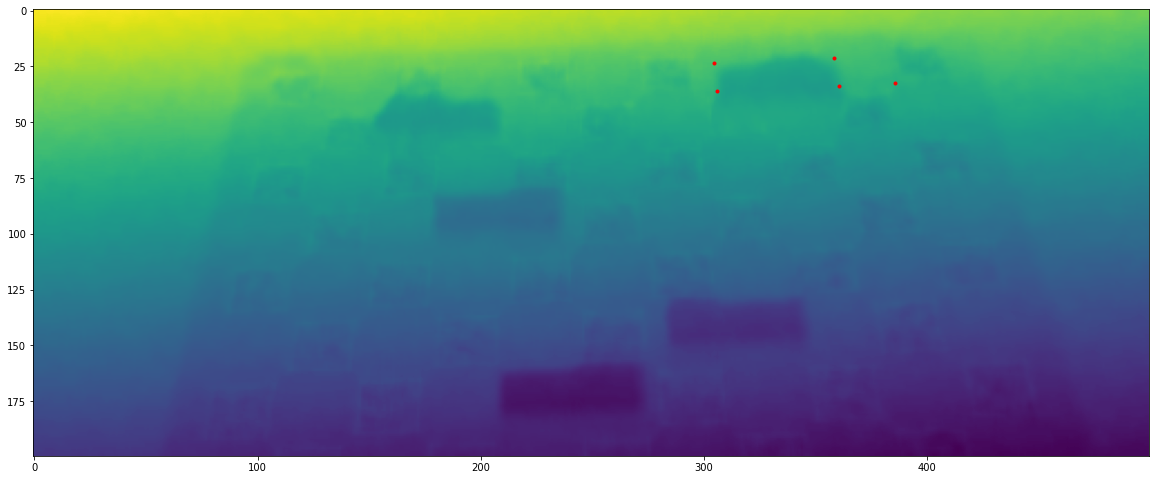

In [7]:
plt.subplots(figsize=(20,20))
plt.imshow(kinect_depth[300:500,400:900])
plt.plot(imgpoints2[:,0]-400,imgpoints2[:,1]-300,"r.")

## Define Camera Calibration

In [8]:
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [9]:
cam_config ={"image_size":np.array(kinect_img).shape[:2],
                   "intrinsics":intrinsic_better,
                   "position":translation,
                   "rotation":rotation}
cam_config

{'image_size': (720, 1280),
 'intrinsics': array([[625.222229  ,   0.        , 638.07092634],
        [  0.        , 624.22393799, 368.16188378],
        [  0.        ,   0.        ,   1.        ]]),
 'position': array([[ 0.12691925],
        [-0.0308574 ],
        [ 0.53732928]]),
 'rotation': array([[-0.51891813],
        [ 0.59914461],
        [ 1.47405833]])}

## Generate PointCloud

(720, 1280, 3)


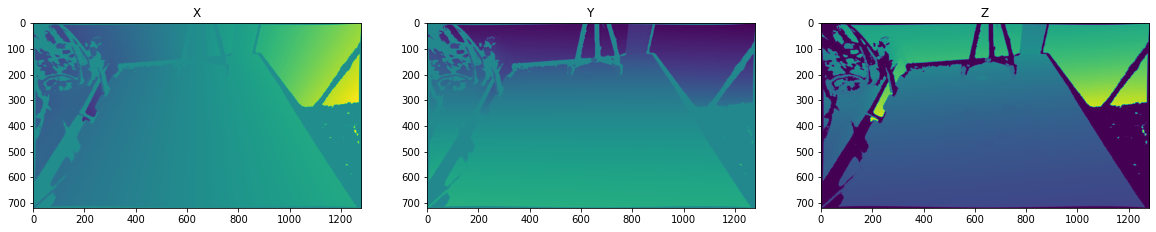

In [10]:

camera = cam_config
depth = kinect_depth
color = kinect_img
xyz = utils.get_pointcloud(depth, camera["intrinsics"])
print(xyz.shape)
f,ax = plt.subplots(figsize=(20,10),ncols=3)
ax = ax.flatten()
ax[0].imshow(xyz[:,:,0])
ax[0].set_title("X")
ax[1].imshow(xyz[:,:,1])
ax[1].set_title("Y")
ax[2].imshow(xyz[:,:,2])
ax[2].set_title("Z")
plt.show()

In [11]:
verts = np.transpose(xyz.reshape(720*1280,3), (1,0))
vis.set_object(g.Points(
    g.PointsGeometry(verts, color=verts),
    g.PointsMaterial()
))

## Transform PointCloud

In [12]:
camera_transformed_translation = np.copy(camera["position"])
camera_transformed_translation[2] = -camera_transformed_translation[2]

camera_transformed_rotation = np.linalg.inv(cv2.Rodrigues(camera["rotation"])[0])
camera_transformed_rotation, camera_transformed_translation

(array([[ 0.00333165,  0.75370068, -0.65720939],
        [-0.99848182,  0.03864195,  0.03925365],
        [ 0.05498136,  0.65608085,  0.75268517]]),
 array([[ 0.12691925],
        [-0.0308574 ],
        [-0.53732928]]))

(720, 1280, 3)


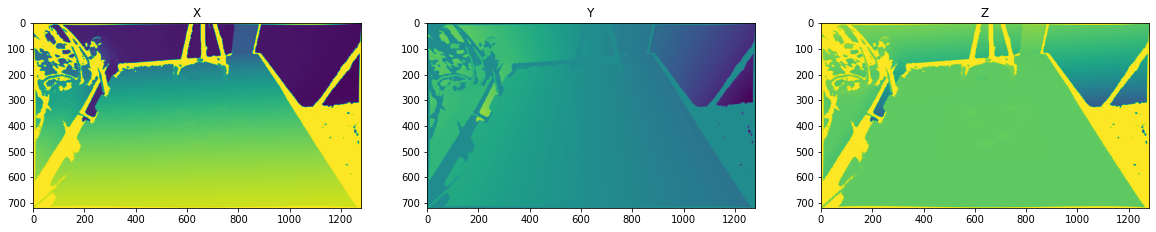

In [13]:
transform = np.eye(4)
transform[:3, :] = np.hstack((camera_transformed_rotation, camera_transformed_translation))
xyz_trans = utils.transform_pointcloud(xyz, transform)
xyz_trans[:,:,2] = xyz_trans[:,:,2]*-1
print(xyz_trans.shape)
f,ax = plt.subplots(figsize=(20,10),ncols=3)
ax = ax.flatten()
ax[0].imshow(xyz_trans[:,:,0])
ax[0].set_title("X")
ax[1].imshow(xyz_trans[:,:,1])
ax[1].set_title("Y")
ax[2].imshow(xyz_trans[:,:,2])
ax[2].set_title("Z")
plt.show()

In [14]:
verts = np.transpose(xyz_trans.reshape(720*1280,3), (1,0))
vis.set_object(g.Points(
    g.PointsGeometry(verts, color=verts),
    g.PointsMaterial()
))

#### Transform PointCloud to Real Point

In [15]:
zero_point = np.array([[[0.0,0.0,0.0]]])

zero_image_point, _ = cv2.projectPoints(zero_point, rotation, translation, intrinsic_better, np.array([]))
zero_image_point = np.squeeze(zero_image_point).astype(int)


In [16]:
y_range, x_range = np.where((xyz_trans[:,:,0] > 0.0) & (xyz_trans[:,:,0] < 0.001) & (xyz_trans[:,:,1] > 0.0) & (xyz_trans[:,:,1] < 0.001))
#print(x_range, y_range)
real_zero_point = [x_range[0],y_range[0]]
real_zero_point

[622, 641]

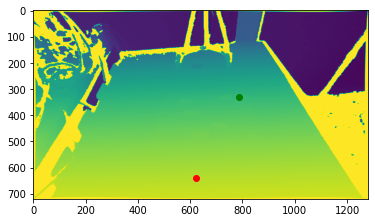

In [17]:
plt.imshow(xyz_trans[:,:,0])
plt.plot(real_zero_point[0],real_zero_point[1], "ro")
plt.plot(zero_image_point[0],zero_image_point[1], "go")

In [18]:
xyz_trans[:,:,0][zero_image_point[1],zero_image_point[0]]

-0.2516539

In [19]:
zero_image_point-real_zero_point

array([ 163, -309])

In [21]:
camera_transformed_translation_2 = np.array([[-xyz_trans[:,:,0][zero_image_point[1],zero_image_point[0]],
                                    -xyz_trans[:,:,1][zero_image_point[1],zero_image_point[0]],
                                    -xyz_trans[:,:,2][zero_image_point[1],zero_image_point[0]]]]).T
camera_transformed_translation_2

array([[ 0.2516539 ],
       [ 0.13772641],
       [-0.14388034]], dtype=float32)

In [22]:
transform = np.eye(4)
transform[:3, :] = np.hstack((np.eye(3), camera_transformed_translation_2))
xyz_trans_true = utils.transform_pointcloud(xyz_trans, transform)


In [24]:
verts = np.transpose(xyz_trans_true.reshape(720*1280,3), (1,0))
vis.set_object(g.Points(
    g.PointsGeometry(verts, color=verts),
    g.PointsMaterial()
))

In [ ]:
0.025*

In [25]:
bounds = np.array([[ -0.025,  0.175],
       [-0.025 ,  0.25 ],
       [ -0.01  ,  0.1]])

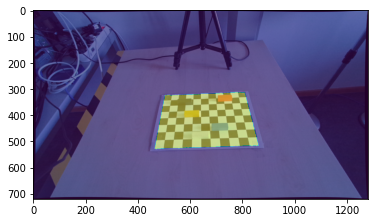

In [28]:
ix = (xyz_trans_true[Ellipsis, 0] >= bounds[0, 0]) & (xyz_trans_true[Ellipsis, 0] < bounds[0, 1])
iy = (xyz_trans_true[Ellipsis, 1] >= bounds[1, 0]) & (xyz_trans_true[Ellipsis, 1] < bounds[1, 1])
iz = (xyz_trans_true[Ellipsis, 2] >= bounds[2, 0]) & (xyz_trans_true[Ellipsis, 2] < bounds[2, 1])
valid = ix & iy & iz

plt.imshow(valid)
plt.imshow(kinect_img, alpha=0.5)
plt.show()
#valid.shape

In [30]:
xyz_trans_filtered = xyz_trans_true[valid]
xyz_trans_filtered.shape

(71605, 3)

In [32]:
verts = np.transpose(xyz_trans_filtered.reshape(71605,3), (1,0))
vis.set_object(g.Points(
    g.PointsGeometry(verts, color=verts),
    g.PointsMaterial()
))

In [33]:
pix_size = 0.003125

In [34]:
color = kinect_img[valid]

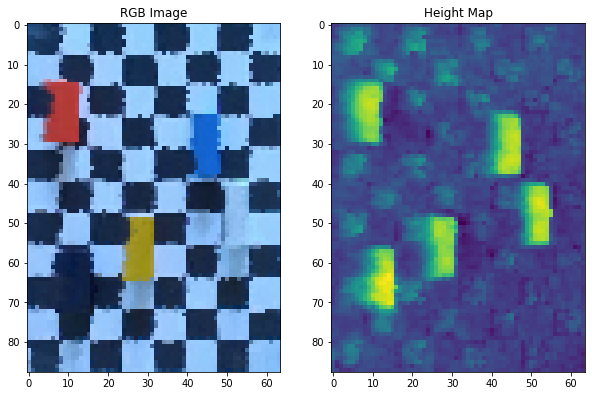

In [35]:
heightmap, colormap = utils.get_heightmap(xyz_trans_filtered, color, bounds, pix_size)
f,ax = plt.subplots(figsize=(10,10),ncols=2,nrows=1)
ax[0].imshow(colormap)
ax[0].set_title("RGB Image")
ax[1].set_title("Height Map")
ax[1].imshow(heightmap)